# PYTHON FOR DATA ANALYSIS


In [306]:
## We import all the librairies needed for the analysis.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
import os
import seaborn as sns

## 1. DATA PREPARATION
***

### 1.1 DATASET DESCRIPTION
  ***

    1.  fLength:  continuous  # major axis of ellipse [mm]
    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
    10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
    11.  class:    g,h         # gamma (signal), hadron (background)
    
*__All values are actually float, except for class which is an object with two possible values.__*

***
    

### 1.2 DATABASE DOWNLOADING
***

In [270]:
## We download the dataset directly from our folder

path="plop.csv"
dataset=pd.read_csv(path,engine="python")
#dataset.head()

In [271]:
## To clarify the dataset, we will rename the columns so it is easier to understand what we are manipulating

nouvelles_colonnes =["Major_Axis", "Minor_Axis", "Size","SizeRatio1", "SizeRatio2", "Highest_to_center", "Major_axis_moment", "Minor_axis_moment" , "Angle", "Distance", "Class"]
dataset.columns = nouvelles_colonnes
dataset.head()

,Major_Axis,Minor_Axis,Size,SizeRatio1,SizeRatio2,Highest_to_center,Major_axis_moment,Minor_axis_moment,Angle,Distance,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


### 1.3 FINALIZING DATA PREP
***

In [272]:
## We verify that the values taken by the class object

dataset.groupby(["Class"])["Class"].count()

Class
g    12332
h     6688
Name: Class, dtype: int64

## 2. DATA VISUALIZATION
***

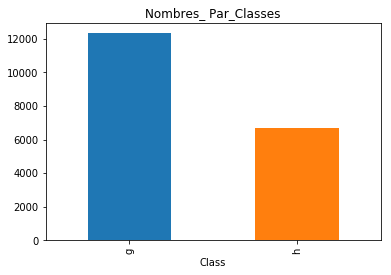

In [273]:
%matplotlib inline
dataset.groupby(["Class"])["Class"].count().plot.bar(title="Nombres_ Par_Classes")

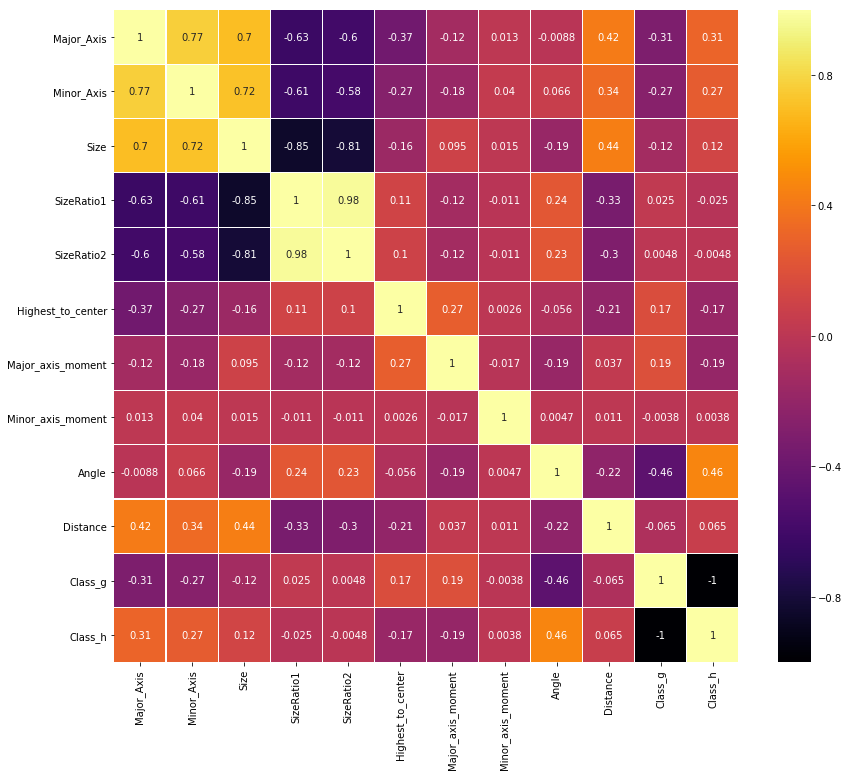

In [318]:
plt.figure(figsize=(14,12))
sns.heatmap(dataset.corr(),linewidths=.1,cmap="inferno", annot=True)
plt.yticks(rotation=0);

## 3. DATA MODELIZATION
***

In [275]:
x = dataset.loc[:, dataset.columns != 'Class']
y = dataset['Class'].values
#y = label_binarize(y,)
dx_train, dx_test, dy_train, dy_test = train_test_split(x, y, test_size=0.2, random_state=1)
dx_train, dx_val, dy_train, dy_val = train_test_split(dx_train, dy_train, test_size=0.2, random_state=1)
dx_train.shape
dx_test.shape
dx_val.shape

(3044, 10)

In [276]:
dataset=pd.get_dummies(dataset) #Turn column class into 2 columns Class_g and Class_h
dataset.shape

(19020, 12)

In [277]:
X = dataset[dataset.columns[:1]]
y = dataset[dataset.columns[-1]]

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [335]:
from sklearn.metrics import accuracy_score

#le modele
algo   = RandomForestClassifier(random_state = 42,
                    n_jobs = -1,
                    n_estimators=16,
                    criterion='entropy',
                    max_depth=16
                    )
#Le fit pour x_train et y_train
modele = algo.fit(X_train, y_train)

# La prédiction
y_pred = algo.predict(X_test)

#Le resultat
accuracy_score(y_test, y_pred)

0.7116719242902209

In [347]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
r ={}
param_grid = {  'min_samples_split' : [10],
                'n_estimators': [56],
                'max_depth' :range(10)[1:],
              "criterion" : ["gini", "entropy"]
}
scorers = { 'precision_score': make_scorer(precision_score) ,
            'recall_score'   : make_scorer(recall_score)    ,
            'accuracy_score' : make_scorer(accuracy_score)  }
skf = StratifiedKFold(n_splits=3)

grid_search= GridSearchCV(clf,
                          param_grid,
                          scoring=scorers,
                          refit='precision_score',
                          cv=skf,
                          return_train_score=True,
                          n_jobs=11)

grid_search.fit(X_train.values,y_train.values)
y_pred = grid_search.predict(X_test.values)
print(grid_search.best_params_)
results = pd.DataFrame()
r[str(param_grid)] =  grid_search.best_score_
grid_search.best_score_

{'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 56}


0.8913850584897387

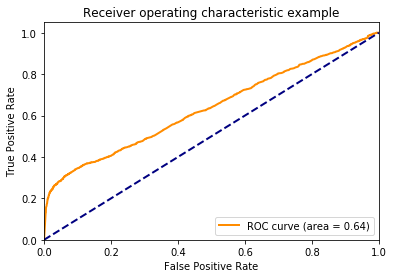

In [336]:
y_pred = modele.predict_proba(X_test)
taux_de_faux_positif, taux_de_vrai_positifs, seuils =  roc_curve(y_test, y_pred[:, 1])

auc_global = auc(taux_de_faux_positif, taux_de_vrai_positifs)
auc_global

plt.figure()
lw = 2
plt.plot(taux_de_faux_positif, 
         taux_de_vrai_positifs, 
         color='darkorange',
         lw=lw, 
         label='ROC curve (area = %0.2f)' % auc_global)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
